# Energy production & consumption forecast

This project compiles many time series forecasting models and compares their performances. The models introduced are :

*   ARIMA
*   ARIMAX
*   Prophet (Facebook)
*   LSTM
*   Chronos (Amazon)

Done using the Our World in Data Energy dataset : https://github.com/owid/energy-data?tab=readme-ov-file


## Imports & prerequisits

In [ ]:
!pip install pmdarima

In [ ]:
!pip install --upgrade statsmodels

In [ ]:
!pip install autogluon

In [ ]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

In [ ]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

Connect the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/'Colab Notebooks'/'Time series'

path = "/content/drive/MyDrive/Colab Notebooks/Time series/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Energy production & consumption forecast.ipynb'   owid-energy-data.csv   owid-energy-data.json


***

Let's start by reading the data from the json and putting the dataframe into shape :

In [ ]:
import json

with open(path + "owid-energy-data.json", 'r', encoding='utf-8') as f:
  data = json.load(f)

In [ ]:
all_data = []

for region, region_data in data.items():
    for entry in region_data["data"]:
        entry["region"] = region
        all_data.append(entry)

df = pd.DataFrame(all_data)
columns = ['region'] + [col for col in df.columns if col != 'region']
df = df[columns]

In [ ]:
df.head()

,region,year,biofuel_electricity,biofuel_share_elec,carbon_intensity_elec,coal_electricity,coal_share_elec,electricity_demand,electricity_generation,fossil_electricity,fossil_share_elec,gas_electricity,gas_share_elec,greenhouse_gas_emissions,hydro_electricity,hydro_share_elec,low_carbon_electricity,low_carbon_share_elec,nuclear_electricity,nuclear_share_elec,oil_electricity,oil_share_elec,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_electricity,renewables_share_elec,solar_electricity,solar_share_elec,wind_electricity,wind_share_elec,population,coal_prod_per_capita,coal_production,gas_prod_per_capita,gas_production,coal_prod_change_twh,gas_prod_change_twh,gdp,coal_prod_change_pct,gas_prod_change_pct,energy_per_capita,energy_per_gdp,oil_prod_per_capita,oil_production,primary_energy_consumption,energy_cons_change_pct,energy_cons_change_twh,oil_prod_change_twh,biofuel_elec_per_capita,coal_elec_per_capita,fossil_elec_per_capita,gas_elec_per_capita,hydro_elec_per_capita,low_carbon_elec_per_capita,net_elec_imports,net_elec_imports_share_demand,nuclear_elec_per_capita,oil_elec_per_capita,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,per_capita_electricity,renewables_elec_per_capita,solar_elec_per_capita,wind_elec_per_capita,oil_prod_change_pct,coal_cons_per_capita,coal_consumption,coal_share_energy,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_energy,gas_consumption,gas_energy_per_capita,gas_share_energy,hydro_consumption,hydro_energy_per_capita,hydro_share_energy,low_carbon_consumption,low_carbon_energy_per_capita,low_carbon_share_energy,nuclear_consumption,nuclear_energy_per_capita,nuclear_share_energy,oil_consumption,oil_energy_per_capita,oil_share_energy,renewables_consumption,renewables_energy_per_capita,renewables_share_energy,wind_consumption,wind_energy_per_capita,wind_share_energy,coal_cons_change_pct,coal_cons_change_twh,fossil_cons_change_pct,fossil_cons_change_twh,gas_cons_change_pct,gas_cons_change_twh,hydro_cons_change_pct,hydro_cons_change_twh,low_carbon_cons_change_pct,low_carbon_cons_change_twh,nuclear_cons_change_twh,oil_cons_change_pct,oil_cons_change_twh,renewables_cons_change_pct,renewables_cons_change_twh,wind_cons_change_twh,other_renewable_consumption,other_renewables_energy_per_capita,other_renewables_share_energy,solar_consumption,solar_energy_per_capita,solar_share_energy,other_renewables_cons_change_pct,other_renewables_cons_change_twh,solar_cons_change_twh,electricity_share_energy,nuclear_cons_change_pct,biofuel_cons_per_capita,biofuel_consumption,biofuel_share_energy,biofuel_cons_change_twh,wind_cons_change_pct,solar_cons_change_pct,biofuel_cons_change_pct
0,ASEAN (Ember),2000,5.87,1.550408,569.557068,76.029999,20.081350,378.609985,378.609985,305.359985,80.652916,164.259995,43.385014,215.639999,50.450001,13.325058,73.250000,19.347086,0.0,0.0,65.070000,17.186552,22.799999,16.930000,6.022028,4.471620,73.250000,19.347086,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ASEAN (Ember),2001,6.46,1.595653,567.642273,86.260002,21.306656,404.850006,404.850006,327.660004,80.933678,190.410004,47.032234,229.809998,54.330002,13.419785,77.190002,19.066320,0.0,0.0,50.990002,12.594788,22.860001,16.400000,5.646536,4.050883,77.190002,19.066320,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

***

## Production Data

The goal here is to proceed manualy to try and forecast the production for one of the energy sources.

To do so we'll try multiple forecasting models and see how they perform to forecast with our data.

As a starter we'll begin by sticking to only the USA and we'll study the oil, gas and coal productions since year 1900.

In [ ]:
countries = ["United States"]

dfCountry = df[df['region'].isin(countries)]

In [ ]:
dfProduction = dfCountry[['region', 'year', 'coal_production', 'oil_production', 'gas_production']]

In [ ]:
import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Scatter(x=dfProduction['year'], y=dfProduction['coal_production'],
                    mode='lines+markers',
                    name='coal'))
fig.add_trace(go.Scatter(x=dfProduction['year'], y=dfProduction['oil_production'],
                    mode='lines+markers',
                    name='oil'))
fig.add_trace(go.Scatter(x=dfProduction['year'], y=dfProduction['gas_production'],
                    mode='lines+markers',
                    name='gas'))

fig.update_layout(title='Production over time', xaxis_title='Year', yaxis_title='production')

fig.show()

### ARIMA

The ARIMA models combine two models and one method. These are:

*   Auto Regression(AR)
*   Moving Average(MA)
*   Differencing for stationarity(I)

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where: p is the number of autoregressive terms(AR), d is the number of nonseasonal differences needed for stationarity(I), and q is the number of lagged forecast errors in the prediction equation(MA).

One of the preprocessing steps is to determine the optimal orders **(p, d, q)** of our ARIMA model. The simplest one is the order of differencing d as this can be verified by carrying out a statistical test for stationarity. The most popular one is the Augmented Dickey-Fuller (ADF), where the null hypothesis is that the time series is not stationary.

d refers to the number of differencing transformations required by the time series to get stationary. So we can use pandas 'diff()' function once or more and recall stationarity function to find the d-value.  If the P-value of Dickey-Fuller test is less than 0.05, the column is stationary, otherwise it is not stationary.

In [ ]:
col = 'coal_production'

In [ ]:
dfProduction = dfProduction.fillna(method='bfill')

<ipython-input-58-e45ea115d6b7>:1: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



The function stationarity will ease the process by returning d (number of differenciations) and the associated P-value.

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def stationarity(col):
  d = 0
  diff_col = col.dropna()
  res = adfuller(diff_col)

  while res[1] > 0.05:
    d += 1
    diff_col = diff_col.diff().dropna()
    res = adfuller(diff_col)
    print("\nTest Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] > 0.05:
      print("Non-Stationary")
    else:
      print("Stationary")
  return diff_col, d

diff_col, d = stationarity(dfProduction[col])


Test Statistic: -5.980681415167907
P-Value: 1.841703383077842e-07
Stationary


The autoregressive and moving-average orders (p,q) can be deduced by analysing the partial autocorrelation function (PACF) and autocorrelation function respectively. The gist of of this method is to plot a correlogram of the various lags/forecast errors of the time series to determine which are statistically significant.

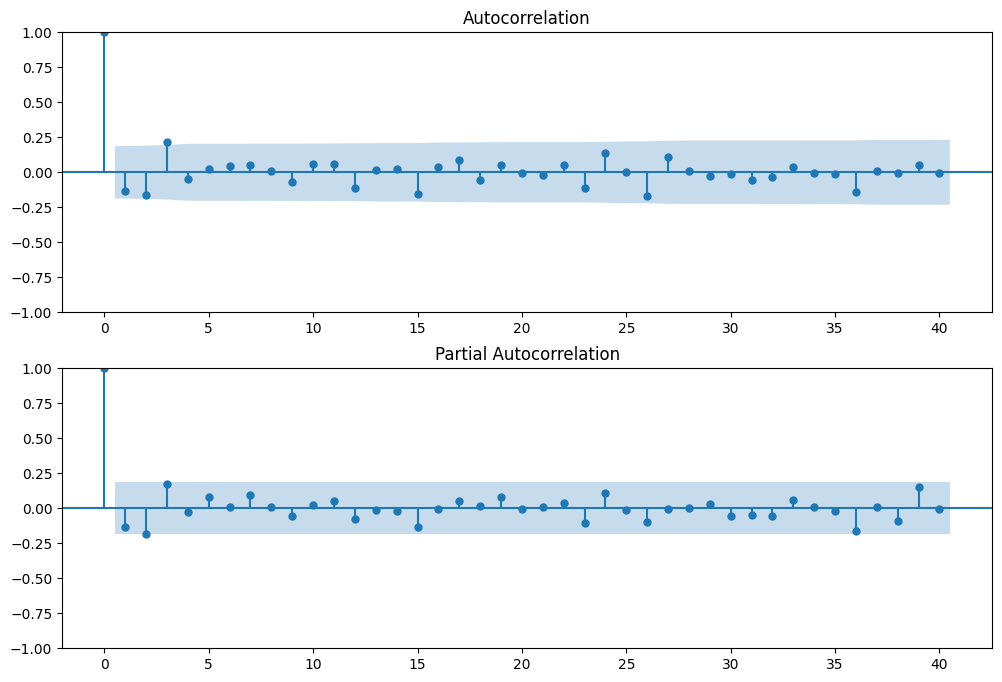

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_col.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_col.iloc[13:],lags=40,ax=ax2)

We can use the Autocorrelation plot to get q and the Partial Autocorrelation one to get p.

We then split our dataset into training and testing set :

In [ ]:
train_size = int(len(dfProduction) * 0.8)  # 80% for training
train, test = dfProduction[:train_size], dfProduction[train_size:]

We define the model with the parameters p, d, q. If p and q are equal to 0 it gives us an ARIMA(0, 1, 0). It then becomes an ARMA(0, 0) when differenced, which is random, uncorrelated, noise (random walk). The sum of noise terms has a mean of 0 : the expected position is still the starting point, but the variance around it increases over time.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = ARIMA(train[col], order=(0,d,0))
model_fit = model.fit()
#model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



We use the model to forecast on the test set

In [ ]:
testForecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



Finally we can plot the predictions on the test set and compare it with the actual ones :

In [ ]:
import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Scatter(x=test['year'], y=test[col],
                    mode='lines+markers',
                    name='Actual'))
fig.add_trace(go.Scatter(x=test['year'], y=testForecast,
                    mode='lines+markers',
                    name='Predicted'))

We now try to predict future values :

In [ ]:
steps = 10
forecast = model_fit.predict(start=1, end=len(dfProduction)+steps)

year = [i for i in range(dfProduction['year'].tolist()[0],dfProduction['year'].tolist()[-1]+steps)]
#year = [i for i in range(dfProduction['year'].tolist()[-1],dfProduction['year'].tolist()[-1]+steps)]


forecastList = list(zip(year, forecast))

dfForecast = pd.DataFrame(forecastList,
                  columns=['year', 'forecast'])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Scatter(x=dfProduction['year'], y=dfProduction[col],
                    mode='lines+markers',
                    name=col))
fig.add_trace(go.Scatter(x=dfForecast['year'], y=dfForecast['forecast'],
                    mode='lines+markers',
                    name='future_predictions'))
fig.add_trace(go.Scatter(x=test['year'], y=testForecast,
                    mode='lines+markers',
                    name='test_predictions'))

fig.update_layout(title=f"{col} forecast", xaxis_title='Year', yaxis_title='production')

fig.show()

Note : We can also use auto_arima to find the optimal p, d, q for our model, which we will use in the coming part : ARIMAX.

***

### ARIMAX

The **ARIMAX (AutoRegressive Integrated Moving Average with Exogenous Variables)** model is an extension of ARIMA that incorporates exogenous variables (X variables) to improve forecasting accuracy. It is a good model to use when there is an external factor (exogenous variable) influencing the time series.

First we'll test the model by training it on a training set and testing it with a test set. We are going to partition both the endogenous and exogenous values.

In [ ]:
df = dfCountry.set_index('year')
endog = df[col]
exog = df[['gdp', 'population', 'primary_energy_consumption', 'coal_production', 'gas_production']]

endog = endog.interpolate(method='linear', limit_direction='both')
exog = exog.interpolate(method='linear', limit_direction='both')

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

future_steps = 5

train_size = int(len(endog) * 0.8)

endog_train, endog_test = endog[:train_size], endog[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

auto_model = pm.auto_arima(
    endog_train,                    # Time series data
    start_p=0,               # Minimum p
    start_q=0,               # Minimum q
    max_p=10,                 # Maximum p
    max_q=10,                 # Maximum q
    d= None,                  # Let the model determine differencing (d)
    seasonal=False,          # Set to True if you want seasonal ARIMA
    trace=True,              # Show the selection process
    stepwise=True,           # Use stepwise search to reduce computation
    information_criterion='aic'  # Optimize based on AIC (can be 'bic' or 'hqic')
)

best_p, best_d, best_q = auto_model.order
print(f"Optimal p, d, q: ({best_p}, {best_d}, {best_q})")

model = SARIMAX(endog_train, exog=exog_train, order=(best_p, best_d, best_q))
results = model.fit()

#forecast = results.forecast(steps=len(endog), exog=exog)
forecast = results.forecast(steps=len(exog_test), exog=exog_test)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=exog_test.index, y=endog_test,
                    mode='lines+markers',
                    name='Test'))

fig.add_trace(go.Scatter(x=exog_test.index, y=forecast.to_list(),
                    mode='lines+markers',
                    name='Predicted test'))

We'll then try the model on the whole dataset to have more observations about its behavior.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

future_steps = 5

auto_model = pm.auto_arima(
    endog,                    # Time series data
    start_p=0,               # Minimum p
    start_q=0,               # Minimum q
    max_p=10,                 # Maximum p
    max_q=10,                 # Maximum q
    d= None,                  # Let the model determine differencing (d)
    seasonal=False,          # Set to True if you want seasonal ARIMA
    trace=True,              # Show the selection process
    stepwise=True,           # Use stepwise search to reduce computation
    information_criterion='aic'  # Optimize based on AIC (can be 'bic' or 'hqic')
)

best_p, best_d, best_q = auto_model.order
print(f"Optimal p, d, q: ({best_p}, {best_d}, {best_q})")

model = SARIMAX(endog, exog=exog, order=(best_p, best_d, best_q))
results = model.fit()

forecast = results.forecast(steps=len(endog), exog=exog)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=endog.index, y=endog,
                    mode='lines+markers',
                    name='Test'))

fig.add_trace(go.Scatter(x=endog.index, y=forecast.to_list(),
                    mode='lines+markers',
                    name='Predicted test'))

In this 3rd step wea re now going to try and predict the future values for the coming years. TO do so we'll need the exogenous values for these years.

We are going to approximate each of the future exogneous values (column) by using a simple linear regression with polynomial features. This model isn't optimal but it is quite simple and very well fitting for values with an exponential growth such as 'gdp' or 'population'.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

future_steps = 5

future_years = np.arange(df.index[-1] + 1, df.index[-1] + future_steps + 1)
prediction_years = np.concatenate([df.index, future_years])
prediction_years = prediction_years.reshape(-1, 1)

exog_pred = pd.DataFrame(columns=exog.columns)

def relu(x):
    return np.maximum(0, x)

for col in exog.columns:
  X = df.index.values.reshape(-1, 1)
  y = exog[col].values

  poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
  poly_model.fit(X, y)

  y_pred = relu(poly_model.predict(prediction_years))

  exog_pred[col] = y_pred[-future_steps:].tolist()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=X.flatten(), y=y,mode='lines+markers', name='Actual'))
  fig.add_trace(go.Scatter(x=prediction_years.flatten(), y=y_pred, mode='lines+markers', name= f'Actual + {future_steps} steps prediction'))
  fig.show()

Note that we use the **ReLu (Rectified Linear Unit)** function to prevent negative predictions.

Now that we have our predicted exogenous values we can train the ARIMAX with the endogenous and exogenous values and then predict using the predicted exogenous values.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Fit auto_arima model
auto_model = pm.auto_arima(
    endog,                    # Your time series data
    start_p=0,               # Minimum p
    start_q=0,               # Minimum q
    max_p=10,                 # Maximum p
    max_q=10,                 # Maximum q
    d= None,                  # Let the model determine differencing (d)
    seasonal=False,          # Set to True if you want seasonal ARIMA
    trace=True,              # Show the selection process
    stepwise=True,           # Use stepwise search to reduce computation
    information_criterion='aic'  # Optimize based on AIC (can be 'bic' or 'hqic')
)

best_p, best_d, best_q = auto_model.order
print(f"Optimal p, d, q: ({best_p}, {best_d}, {best_q})")

model = SARIMAX(endog, exog=exog, order=(best_p, best_d, best_q))
results = model.fit()

#forecast = results.forecast(steps=future_steps, exog=exog[-future_steps:])
forecast = results.forecast(steps=future_steps, exog=exog_pred)

new_index = [i for i in range(exog.index[-1]+1, exog.index[-1]+future_steps+1)]
forecast = forecast.set_axis(new_index)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=endog.index, y=endog,
                    mode='lines+markers',
                    name='Actual'))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast,
                    mode='lines+markers',
                    name='Predicted'))

***

### Prophet

Prophet is an additive time series forecasting model that’s designed to work well with data that has:

*   Seasonality (daily, weekly, yearly patterns).
*   Trends (growth, decline, plateaus).
*   Holidays/Special Events (big spikes or dips).

It’s built to be robust to missing data and outliers, which is a common headache with other models.

In [ ]:
pip install prophet

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.DataFrame({
    'ds': dfCountry['year'],
    'y': dfCountry[col]
})

data['ds'] = pd.to_datetime(data['ds'].astype(str) + '-01-01')

data = data[['ds', 'y']]

We disable seasonality because we have no use of it.

In [ ]:
model = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False)
model.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmploictmsf/hm9jjap_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmploictmsf/mdovx3l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58205', 'data', 'file=/tmp/tmploictmsf/hm9jjap_.json', 'init=/tmp/tmploictmsf/mdovx3l6.json', 'output', 'file=/tmp/tmploictmsf/prophet_modelkx54imxb/prophet_model-20250220235038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=10, freq='Y')

forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



We cant to predict for the next 10 years :

In [ ]:
steps = 10

year = [i for i in range(dfProduction['year'].tolist()[-1],dfProduction['year'].tolist()[-1]+steps)]

forecastList = list(zip(year, forecast['trend'][-10:]))

dfForecast = pd.DataFrame(forecastList,
                  columns=['year', 'forecast'])

In [ ]:
import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Scatter(x=dfProduction['year'], y=dfProduction[col],
                    mode='lines+markers',
                    name=col))
fig.add_trace(go.Scatter(x=dfForecast['year'], y=dfForecast['forecast'],
                    mode='lines+markers',
                    name='future_predictions'))


fig.update_layout(title=f"{col} forecast", xaxis_title='Year', yaxis_title='production')

fig.show()

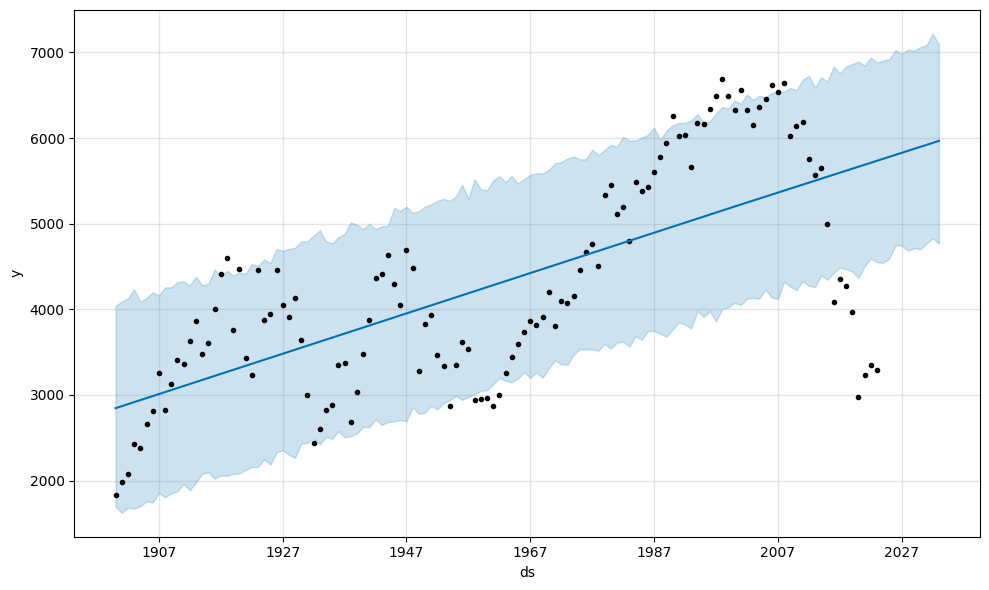

In [ ]:
model.plot(forecast)
plt.show()

***

## LSTM

Long Short-Term Memory is a type of Recurrent Neural Network (RNN). LSTM learns from past values and patterns directly which makes it good when past values influence future values.

Regular RNNs struggle with long-term dependencies whereas the LSTM has a memory cell that helps retain information over long periods.

It decides what to remember and what to forget using three gates:

*   Forget Gate	: Decides what past info to forget.
*   Input Gate : Decides what new info to store.
*   Output Gate	: Decides what to output based on memory.

LSTM remembers long-term trends but adapts when patterns change.

###  1-step-ahead forecast

We predict one step into the future (e.g., next year’s production), then we use that prediction as an input for the next prediction. This process repeats until we reach the desired forecast horizon.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Step 1: Prepare the Data by selecting relevant columns

In [ ]:
PredictData = dfProduction[['year', col]]

PredictData = PredictData.set_index('year')

We scale the data and split it into a training and testing set

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(PredictData.values)

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:]

We define a function to create sequences for the model. It take the dataframe and the number of past time steps to use as input.

In [ ]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length, 0]
        target = data[i+seq_length, 0]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

The sequence length is a key hyperparameter in LSTM models for time series forecasting. It determines how many past observations the model will look at to predict the next value.

In [ ]:
seq_length = 3

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

We build the LSTM model with 100 epochs

In [ ]:
model = Sequential([
LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1) ])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - loss: 0.4215 - val_loss: 0.7851
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.3478 - val_loss: 0.7389
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3362 - val_loss: 0.6956
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3232 - val_loss: 0.6559
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3099 - val_loss: 0.6187
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2544 - val_loss: 0.5840
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2420 - val_loss: 0.5512
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2589 - val_loss: 0.5198
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2156 - val_loss: 0.4905
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1997 - val_loss: 0.4627
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1895 - val_loss: 0.4362
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1915 - va

We then proceed to make predictions on the test set.

In [ ]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=PredictData.index[-len(y_test):], y=y_test.flatten(), mode='lines', name='Actual Data'))
fig.add_trace(go.Scatter(x=PredictData.index[-len(predictions):], y=predictions.flatten(), mode='lines', name='Predictions'))

fig.update_layout(title='y_test vs predictions',
                  xaxis_title='Time',
                  yaxis_title='Value')

fig.show()

This part allow us to forecast on future data. It appends each predicted value to full_sequence to use it for the next prediction.

We will be forecasting on the whole dataset to see how the model behaves. Also, we're not forecasting beyond the last known year so the model should stop at year 2020, 2024 being an unknown value.

In [ ]:
full_sequence = scaled_data.tolist()
predicted_sequence = []

# Predict the entire known sequence
for i in range(seq_length, len(full_sequence)):
    input_sequence = np.array(full_sequence[i - seq_length:i]).reshape(1, seq_length, 1)
    predicted_value = model.predict(input_sequence)[0, 0]
    predicted_sequence.append(predicted_value)

predicted_sequence = np.array(predicted_sequence).reshape(-1, 1)
predicted_sequence = scaler.inverse_transform(predicted_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=PredictData.index, y=PredictData[col], mode='lines', name='Actual Data'))

fig.add_trace(go.Scatter(x=PredictData.index, y=predicted_sequence.flatten(), mode='lines', name='Predictions'))

fig.update_layout(title='LSTM Time Series Forecasting - Full Dataset', xaxis_title='Timestamp', yaxis_title='Value')

fig.show()

We cans see that the model is actually pretty good as its predictions are pretty close to the actual values. The trends are very similar.

Based on this we can combine the 2 precedent steps to then be able to forecast on 10 future steps (i.e 10 years)

In [ ]:
full_sequence = scaled_data.tolist()
predicted_sequence = []

# Predict on the entire known sequence to test the model
for i in range(seq_length, len(full_sequence)):
    input_sequence = np.array(full_sequence[i - seq_length:i]).reshape(1, seq_length, 1)
    predicted_value = model.predict(input_sequence)[0, 0]
    predicted_sequence.append(predicted_value)

# Forecast for 10 future steps
future_steps = 10
input_sequence = np.array(full_sequence[-seq_length:])

for _ in range(future_steps):
    input_sequence_reshaped = input_sequence.reshape(1, seq_length, 1)
    predicted_value = model.predict(input_sequence_reshaped)[0, 0]

    predicted_sequence.append(predicted_value)
    input_sequence = np.append(input_sequence[1:], [[predicted_value]], axis=0)

predicted_sequence = np.array(predicted_sequence).reshape(-1, 1)
predicted_sequence = scaler.inverse_transform(predicted_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
PredictData[col][:3]

,coal_production
year,
1900,1829.394897
1901,1989.593018
1902,2075.748779


In [ ]:
historical_years = PredictData.index[seq_length:]
last_year = PredictData.index[-1]
future_years = [last_year + i + 1 for i in range(future_steps)]

prediction_years = list(historical_years) + future_years

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=PredictData.index, y=PredictData[col], mode='lines', name='Historical Data'))
fig.add_trace(go.Scatter(x=prediction_years, y=predicted_sequence.flatten(), mode='lines+markers', name='Predicted Data'))
fig.add_trace(go.Scatter(x=PredictData.index, y=PredictData[col][:seq_length+1], mode='lines', name='Context (sequence length)'))

fig.update_layout(title='LSTM Forecasting (Historical + 10 Future Steps)', xaxis_title='Year', yaxis_title=col)
fig.show()

###  Multi-step-ahead forecast

WE predict multiple future steps directly on the entire horizon (e.g., next 5 years) at once.

In [ ]:
PredictData = dfProduction[['year', col]]

PredictData = PredictData.set_index('year')

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(PredictData.values)

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:]

In [ ]:
def create_sequences(data, seq_length, horizon):
    sequences, targets = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        sequence = data[i:i + seq_length, 0]
        target = data[i + seq_length:i + seq_length + horizon, 0]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [ ]:
seq_length = 3
horizon = 10

X_train, y_train = create_sequences(train_data, seq_length, horizon)
X_test, y_test = create_sequences(test_data, seq_length, horizon)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(horizon)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.2382 - val_loss: 0.5473
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2224 - val_loss: 0.5342
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2207 - val_loss: 0.5209
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2171 - val_loss: 0.5074
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2091 - val_loss: 0.4934
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2092 - val_loss: 0.4789
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1917 - val_loss: 0.4638
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1817 - val_loss: 0.4479
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1845 - val_loss: 0.4309
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1699 - val_loss: 0.4129
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1677 - val_loss: 0.3935
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1431 - val_loss: 0.3724


In [ ]:
input_sequence = scaled_data[-seq_length:, 0] # Shape (seq_length,)
input_sequence = input_sequence.reshape(1, seq_length, 1)

future_prediction = model.predict(input_sequence)[0] # Shape (horizon,)

future_prediction_unscaled = scaler.inverse_transform(future_prediction.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [ ]:
import plotly.graph_objects as go

last_year = PredictData.index[-1]
future_years = [last_year + i for i in range(1, horizon + 1)]

fig = go.Figure()

fig.add_trace(go.Scatter(x=PredictData.index, y=PredictData[col], mode='lines+markers', name='Historical Data'))

# Plot future predictions
fig.add_trace(go.Scatter(x=future_years, y=future_prediction_unscaled.flatten(), mode='lines+markers', name='Future Prediction (Next 10 Steps)'))

fig.update_layout(
    title=f"Forecasting the Next 10 Years for {col}",xaxis_title="Year",yaxis_title=col
)

fig.show()


***

### Chronos Bolt

Chronos-Bolt is a family of pretrained time series forecasting models which can be used for zero-shot forecasting. It is based on the T5 encoder-decoder architecture and has been trained on nearly 100 billion time series observations. It chunks the historical time series context into patches of multiple observations, which are then input into the encoder. The decoder then uses these representations to directly generate quantile forecasts across multiple future steps—a method known as direct multi-step forecasting.

References :

https://huggingface.co/autogluon/chronos-bolt-small

https://github.com/amazon-science/chronos-forecasting/tree/main


Let's start by training a chronos with a train set and see its performances on a test set

In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

PredictData = dfProduction[['year', col]].copy()
PredictData['item_id'] = 'United States'
PredictData['year'] = pd.to_datetime(PredictData['year'], format='%Y')

#The model only accepts the time as 'timestamp' and values as 'target'
PredictData = PredictData.rename(columns={'year': 'timestamp', col: 'target'})
PredictData = PredictData.set_index(['item_id', 'timestamp'])

PredictData = TimeSeriesDataFrame(PredictData)

train_size = int(len(PredictData) * 0.8)
train, test = PredictData[:train_size], PredictData[train_size:]

predictor = TimeSeriesPredictor(prediction_length=10).fit(
    train,
    presets="high_quality",
    hyperparameters={"Chronos": {"model_path": "autogluon/chronos-bolt-small"},},
)

predictions = predictor.predict(test)

Beginning AutoGluon training...
AutoGluon will save models to '/content/chronos-forecasting/chronos-forecasting/AutogluonModels/ag-20250221_001551'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.92 GB / 12.67 GB (78.2%)
Disk Space Avail:   72.93 GB / 107.72 GB (67.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'autogluon/chronos-bolt-small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 10,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferre

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index.get_level_values('timestamp'), y=PredictData['target'], mode='lines+markers', name='Historical Data'))
fig.add_trace(go.Scatter(x=test.index.get_level_values('timestamp'), y=test['target'], mode='lines+markers', name='Historical Data'))

# Plot future predictions
fig.add_trace(go.Scatter(x=test.index.get_level_values('timestamp'), y=predictions['mean'], mode='lines+markers', name='Future Prediction (Next 10 Steps)'))

fig.update_layout(
    title=f"Forecasting the Next 10 Years for {col}",xaxis_title="Year",yaxis_title=col
)

fig.show()

Then we can forecast for future years

In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

PredictData = dfProduction[['year', col]].copy()
PredictData['item_id'] = 'United States'
PredictData['year'] = pd.to_datetime(PredictData['year'], format='%Y')

#The model only accepts the time as 'timestamp' and values as 'target'
PredictData = PredictData.rename(columns={'year': 'timestamp', col: 'target'})
PredictData = PredictData.set_index(['item_id', 'timestamp'])

PredictData = TimeSeriesDataFrame(PredictData)

predictor = TimeSeriesPredictor(prediction_length=10).fit(
    PredictData,
    presets="high_quality",
    hyperparameters={
        "Chronos": {"model_path": "autogluon/chronos-bolt-small"},
    },
)

predictions = predictor.predict(PredictData)

Beginning AutoGluon training...
AutoGluon will save models to '/content/chronos-forecasting/chronos-forecasting/AutogluonModels/ag-20250221_001559'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.88 GB / 12.67 GB (78.0%)
Disk Space Avail:   72.93 GB / 107.72 GB (67.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'autogluon/chronos-bolt-small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 10,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferre

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=PredictData.index.get_level_values('timestamp'), y=PredictData['target'], mode='lines+markers', name='Historical Data'))

# Plot future predictions
fig.add_trace(go.Scatter(x=predictions.index.get_level_values('timestamp'), y=predictions['mean'], mode='lines+markers', name='Future Prediction (Next 10 Steps)'))

fig.update_layout(
    title=f"Forecasting the Next 10 Years for {col}",xaxis_title="Year",yaxis_title=col
)

fig.show()

***